## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [3]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'
class_name = input('Give me the class name (e.g. "chair"): ').lower()

Give me the class name (e.g. "chair"): chair


Load Point-Clouds

In [4]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

6778 pclouds were loaded. They belong in 1 shape-classes.


Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [5]:
train_params = default_train_params()

In [6]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [7]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

In [8]:
load_pre_trained_ae = False
restore_epoch = 500
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Build AE Model.

In [9]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

W0216 11:49:04.776987 140638938969856 deprecation.py:506] From /home/arafian-admin/Repos/lib/python3.5/site-packages/tflearn/initializations.py:119: calling UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0216 11:49:04.777536 140638938969856 deprecation.py:323] From /home/arafian-admin/Repos/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:507: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_ae_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 

W0216 11:49:05.136448 140638938969856 deprecation.py:323] From /home/arafian-admin/Repos/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


bnorm params =  512
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("single_class_ae_2/Relu_5:0", shape=(?, 256), dtype=float32)
output size: 256 

decoder_fc_1 FC params =  65792 Tensor("single_class_ae_2/Relu_6:0", shape=(?, 256), dtype=float32)
output size: 256 

decoder_fc_2 FC params =  1579008 Tensor("single_class_ae_2/decoder_fc_2/BiasAdd:0", shape=(?, 6144), dtype=float32)
output size: 6144 



W0216 11:49:05.474650 140638938969856 deprecation.py:506] From /home/arafian-admin/Repos/lib/python3.5/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train the AE (save output to train_stats.txt) 

In [10]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.2075', 'loss=', '0.003565450')
('Epoch:', '0002', 'training time (minutes)=', '0.1723', 'loss=', '0.001733103')
('Epoch:', '0003', 'training time (minutes)=', '0.1722', 'loss=', '0.001476412')
('Epoch:', '0004', 'training time (minutes)=', '0.1721', 'loss=', '0.001337753')
('Epoch:', '0005', 'training time (minutes)=', '0.1722', 'loss=', '0.001254274')
('Epoch:', '0006', 'training time (minutes)=', '0.1726', 'loss=', '0.001166880')
('Epoch:', '0007', 'training time (minutes)=', '0.1722', 'loss=', '0.001126228')
('Epoch:', '0008', 'training time (minutes)=', '0.1725', 'loss=', '0.001093262')
('Epoch:', '0009', 'training time (minutes)=', '0.1724', 'loss=', '0.001057318')
('Epoch:', '0010', 'training time (minutes)=', '0.1784', 'loss=', '0.001037088')
('Epoch:', '0011', 'training time (minutes)=', '0.1813', 'loss=', '0.001004927')
('Epoch:', '0012', 'training time (minutes)=', '0.1746', 'loss=', '0.000994343')
('Epoch:', '0013', 'training

('Epoch:', '0103', 'training time (minutes)=', '0.1727', 'loss=', '0.000618714')
('Epoch:', '0104', 'training time (minutes)=', '0.1727', 'loss=', '0.000617464')
('Epoch:', '0105', 'training time (minutes)=', '0.1726', 'loss=', '0.000610150')
('Epoch:', '0106', 'training time (minutes)=', '0.1726', 'loss=', '0.000601739')
('Epoch:', '0107', 'training time (minutes)=', '0.1726', 'loss=', '0.000618410')
('Epoch:', '0108', 'training time (minutes)=', '0.1724', 'loss=', '0.000603490')
('Epoch:', '0109', 'training time (minutes)=', '0.1728', 'loss=', '0.000607631')
('Epoch:', '0110', 'training time (minutes)=', '0.1727', 'loss=', '0.000610387')
('Epoch:', '0111', 'training time (minutes)=', '0.1727', 'loss=', '0.000615240')
('Epoch:', '0112', 'training time (minutes)=', '0.1728', 'loss=', '0.000601037')
('Epoch:', '0113', 'training time (minutes)=', '0.1726', 'loss=', '0.000601054')
('Epoch:', '0114', 'training time (minutes)=', '0.1725', 'loss=', '0.000598679')
('Epoch:', '0115', 'training

('Epoch:', '0205', 'training time (minutes)=', '0.1754', 'loss=', '0.000541193')
('Epoch:', '0206', 'training time (minutes)=', '0.1757', 'loss=', '0.000537303')
('Epoch:', '0207', 'training time (minutes)=', '0.1738', 'loss=', '0.000540070')
('Epoch:', '0208', 'training time (minutes)=', '0.1729', 'loss=', '0.000532986')
('Epoch:', '0209', 'training time (minutes)=', '0.1788', 'loss=', '0.000531110')
('Epoch:', '0210', 'training time (minutes)=', '0.1728', 'loss=', '0.000538313')
('Epoch:', '0211', 'training time (minutes)=', '0.1741', 'loss=', '0.000531115')
('Epoch:', '0212', 'training time (minutes)=', '0.1773', 'loss=', '0.000534390')
('Epoch:', '0213', 'training time (minutes)=', '0.1759', 'loss=', '0.000532379')
('Epoch:', '0214', 'training time (minutes)=', '0.1744', 'loss=', '0.000543066')
('Epoch:', '0215', 'training time (minutes)=', '0.1761', 'loss=', '0.000532192')
('Epoch:', '0216', 'training time (minutes)=', '0.1742', 'loss=', '0.000531215')
('Epoch:', '0217', 'training

('Epoch:', '0307', 'training time (minutes)=', '0.1728', 'loss=', '0.000503411')
('Epoch:', '0308', 'training time (minutes)=', '0.1727', 'loss=', '0.000501249')
('Epoch:', '0309', 'training time (minutes)=', '0.1728', 'loss=', '0.000505777')
('Epoch:', '0310', 'training time (minutes)=', '0.1727', 'loss=', '0.000498523')
('Epoch:', '0311', 'training time (minutes)=', '0.1728', 'loss=', '0.000496385')
('Epoch:', '0312', 'training time (minutes)=', '0.1727', 'loss=', '0.000501546')
('Epoch:', '0313', 'training time (minutes)=', '0.1728', 'loss=', '0.000497293')
('Epoch:', '0314', 'training time (minutes)=', '0.1728', 'loss=', '0.000505019')
('Epoch:', '0315', 'training time (minutes)=', '0.1728', 'loss=', '0.000504539')
('Epoch:', '0316', 'training time (minutes)=', '0.1728', 'loss=', '0.000497854')
('Epoch:', '0317', 'training time (minutes)=', '0.1730', 'loss=', '0.000493844')
('Epoch:', '0318', 'training time (minutes)=', '0.1727', 'loss=', '0.000499502')
('Epoch:', '0319', 'training

('Epoch:', '0409', 'training time (minutes)=', '0.1727', 'loss=', '0.000479034')
('Epoch:', '0410', 'training time (minutes)=', '0.1725', 'loss=', '0.000486097')
('Epoch:', '0411', 'training time (minutes)=', '0.1725', 'loss=', '0.000487326')
('Epoch:', '0412', 'training time (minutes)=', '0.1724', 'loss=', '0.000486750')
('Epoch:', '0413', 'training time (minutes)=', '0.1725', 'loss=', '0.000477301')
('Epoch:', '0414', 'training time (minutes)=', '0.1724', 'loss=', '0.000484382')
('Epoch:', '0415', 'training time (minutes)=', '0.1725', 'loss=', '0.000485120')
('Epoch:', '0416', 'training time (minutes)=', '0.1724', 'loss=', '0.000482354')
('Epoch:', '0417', 'training time (minutes)=', '0.1724', 'loss=', '0.000478497')
('Epoch:', '0418', 'training time (minutes)=', '0.1725', 'loss=', '0.000477640')
('Epoch:', '0419', 'training time (minutes)=', '0.1777', 'loss=', '0.000487956')
('Epoch:', '0420', 'training time (minutes)=', '0.1768', 'loss=', '0.000486682')
('Epoch:', '0421', 'training

Get a batch of reconstuctions and their latent-codes.

In [11]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

Use any plotting mechanism such as matplotlib to visualize the results.

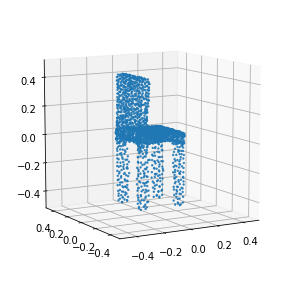

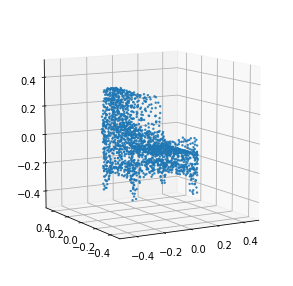

In [12]:
i = 2
plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);

i = 4
plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);